# Hospital DTW Clustering

## imports

In [79]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

import pandas as pd
from cluster_dtw import *
import matplotlib.pyplot as plt
import json
import pickle

## Settings

In [80]:

#ETABS = ETAB_NAMES
# ETABS = [etab[1] for etab in ETAB_NAMES]
# ETABS = []
#ETABS = ['CHU Dijon', 'HNFC', 'CH Beaune']
#ETABS = ['CH Chaumont']

ENDOGENOUS = True
EXOGENOUS = False

TARGET = 'urgences'
assert TARGET in ['urgences', 'hospits']

AGE = 'adults'
assert AGE in ['adults', 'children']

OUTLIERS = True
OUTLIERS_PATH = './outliers_etabs.json'

DATA_DIR = '../data/datasets/'

SAVE_DIR = './result_clusters_56/' + TARGET + (f'_{AGE}' if TARGET == 'hospits' else '') + (' (without outliers)' if not OUTLIERS else '') + '/'

if TARGET == 'urgences':
    target_column = 'target_hospital_nb_emmergencies%J+3%mean_3J'
elif TARGET == 'hospits' and AGE == 'adults':
    target_column = 'target_hospital_nb_hospit_np_from_ED_adults%J+7%mean_7J'
elif TARGET == 'hospits' and AGE == 'children':
    target_column = 'target_hospital_nb_hospit_np_from_ED_children%J+7%mean_7J'


n_clusters = [2]

In [81]:
print(os.path.exists(DATA_DIR))

True


In [82]:
if SAVE_DIR != None:
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR, exist_ok=True)

In [83]:
print(os.listdir(DATA_DIR))

['full_dataset_GROUPEMENT HOSPITALIER DE HAUTE SAONE.csv', 'full_dataset_CH AUXERRE_targets_urgences.csv', 'full_dataset_HÔPITAL PRIVÉ DIJON BOURGOGNE.csv', 'full_dataset_CLINIQUE MÉDICO-CHIRURGICALE DE CHENOVE.csv', 'full_dataset_CH COSNE COURS SUR LOIRE_targets_hospits.csv', 'full_dataset_CH LOUIS JAILLON SAINT CLAUDE_targets_hospits.csv', 'full_dataset_POLYCLINIQUE STE MARGUERITE AUXERRE.csv', 'full_dataset_CH CHARTRES.csv', 'full_dataset_CH DECIZE.csv', 'full_dataset_CH J. COEUR BOURGES_targets_urgences.csv', 'full_dataset_CH VENDOME.csv', 'full_dataset_CH CHARTRES_targets_hospits.csv', 'full_dataset_CH JURA SUD_targets_urgences.csv', 'full_dataset_CH LA TOUR BLANCHE ISSOUDUN_targets_urgences.csv', 'full_dataset_CH VENDOME_targets_urgences.csv', "full_dataset_CH D'AVALLON.csv", 'full_dataset_CH VIERZON_targets_hospits.csv', 'full_dataset_CH DU TONNERROIS.csv', 'full_dataset_CH DU VAL DE SAÔNE GRAY_targets_urgences.csv', 'full_dataset_CH LE BLANC.csv', 'full_dataset_CH L PASTEUR

## Functions

In [84]:
def plot_time_series(time_series, date_range, labels, value='Value', title='etabs', cluster='', save_dir=None, legend=True):
    # Plot all three time series
    plt.figure(figsize=(12, 6))
    for i in range(len(labels)):
        plt.plot(date_range, time_series[i], label=labels[i], linewidth=0.5)

    # Add labels, title, and legend
    plt.xlabel('Time')
    plt.ylabel(value)
    title = f'Comparison of {title} {value}'
    plt.title(title)
    if legend: plt.legend()

    plt.grid(True)
    if save_dir != None: plt.savefig(save_dir + f"{title}{cluster}.png", format="png", dpi=300)
    plt.show()

In [85]:
def subplots_time_series(time_series, date_range, labels, value='Value', cluster='', save_dir=None):
    plt.figure(figsize=(10, 15))

    # Subplot for ts
    for i in range(len(labels)):
        plt.subplot(len(labels), 1, i+1)
        plt.plot(date_range, time_series[i], label=labels[i], linewidth=0.5)
        title = f'{labels[i]} {value}'
        plt.title(title)
        plt.grid(True)

    plt.tight_layout()
    if save_dir != None: plt.savefig(save_dir + f"subplots_{value}{cluster}.png", format="png", dpi=300)
    plt.show()

## Loading Data

In [86]:
outlier_list = []
if not OUTLIERS:
    # read json file
    outlier_dic = json.load(open(OUTLIERS_PATH))
    outlier_list = outlier_dic[target_column]
    # for target in outlier_dic.keys():
    #     for etab in outlier_dic[target]:
    #         if etab not in outlier_list:
    #             outlier_list.append(etab)

In [87]:
print(outlier_list)

[]


In [88]:
len(outlier_list)

0

In [89]:
datasets = []
etabs = []
for file in os.listdir(DATA_DIR):
    if file.endswith(TARGET + ".csv"):
        etab = file.split("_")[2]
        if not OUTLIERS and etab in outlier_list: continue
        etabs.append(etab)
        df = pd.read_csv(os.path.join(DATA_DIR, file))
        if not EXOGENOUS: df = df[['date', target_column]]
        df.set_index('date', inplace=True)
        # df = df.drop(df.loc['2020-03':'2020-05'].index) # covid
        # date_range = date_range.drop(df.loc['2020-03':'2020-05'].index)
        # df.loc['2020-03':'2020-05'].plot()
        # print(f'{etabs[-1]} : {df.shape}')
        datasets.append(df)

<Axes: xlabel='date'>

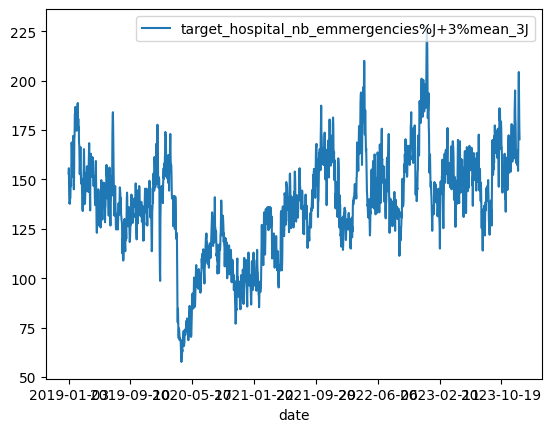

In [90]:
datasets[0].plot()

In [91]:
start_date = datasets[0].index.min()
end_date = datasets[0].index.max()
date_range = pd.date_range(start_date, end_date)

## DTW Clustering

In [92]:
# n_clusters = list(range(2, 11))
clusters, dtw_matrix, n_clusters = cluster_dtw(datasets, n_clusters=n_clusters, scale=True, verbose=True)
clusters_etab = output_clusters([etab for etab in etabs], clusters)

Number of clusters: 2, Silhouette Score: 0.740

Optimal number of clusters: 2 -> [1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 1]
Cluster 1
['CH AUXERRE', 'CH J. COEUR BOURGES', 'CH JURA SUD', 'CHU DE TOURS', 'CH AGGLOMERATION MONTARGOISE', 'CH CHARTRES', 'CH VICTOR JOUSSELIN', 'CH WILLIAM MOREY CHALON SUR SAONE', 'CHU BESANCON', 'CH DE BLOIS', 'CH LES CHANAUX MACON', 'CH SENS', 'HÔPITAL NORD FRANCHE COMTE', 'GROUPEMENT HOSPITALIER DE HAUTE SAONE', 'CH DE CHATEAUROUX', "CH DE L'AGGLOMÉRATION DE NEVERS", 'ORELIANCE - REINE BLANCHE', 'CHU DIJON BOURGOGNE', 'CHR ORLEANS']
Cluster 0
['CH LA TOUR BLANCHE ISSOUDUN', 'CH VENDOME', 'CH DU VAL DE SAÔNE GRAY', 'CH LOCHES', 'HÔPITAL PRIVÉ DIJON BOURGOGNE', 'CH DECIZE', 'CH LE BLANC', 'CH ST AMAND MONTROND', 'CH DE GIEN', 'CH DE CHATEAUDUN', 'CHIC AMBOISE- CHATEAU RENAULT', 'CHIC DE HAUTE-COMTÉ', 'CH CHINONAIS', 'HOSPICES CIVILS DE BEAUNE', 'CH ROBERT MORLEVAT SEMUR EN AUXOIS'

## Saving results

In [93]:
dir = None
if SAVE_DIR != None:
    dir = SAVE_DIR + f'/{n_clusters} Clusters/'
    if not os.path.exists(dir):
        os.mkdir(dir)
    
    # Save dtw matrix
    with open(dir + f'dtw_matrix', 'wb') as f:
       pickle.dump(dtw_matrix, f)

    save_dtw_matrix = {}
    for i in range(len(dtw_matrix)):
        distances = list(dtw_matrix[i])
        save_dtw_matrix[etabs[i]] = {}
        for j in range(len(distances)):
            save_dtw_matrix[etabs[i]][etabs[j]] = distances[j]
    
    with open(dir + f'dtw_matrix.json', 'w') as f:
       json.dump(save_dtw_matrix, f)

    sep = '\n'
    ext = 'txt'
    dico = {}
    for i in range(n_clusters):
        file = f'Cluster {i}'
        dico[file] = []
        print(file + ':')
        list_etabs = ''
        for j in range(len(etabs)):
            if clusters[j] == i:
                list_etabs += f'{etabs[j]}' + sep
                dico[file].append(etabs[j])
        print(list_etabs)
        with open(dir + f'{file}.{ext}', 'w') as f:
            f.write(list_etabs)
    with open(dir + f"Clusters.json", "w") as json_file:
        json.dump(dico, json_file, indent=4)

Cluster 0:
CH LA TOUR BLANCHE ISSOUDUN
CH VENDOME
CH DU VAL DE SAÔNE GRAY
CH LOCHES
HÔPITAL PRIVÉ DIJON BOURGOGNE
CH DECIZE
CH LE BLANC
CH ST AMAND MONTROND
CH DE GIEN
CH DE CHATEAUDUN
CHIC AMBOISE- CHATEAU RENAULT
CHIC DE HAUTE-COMTÉ
CH CHINONAIS
HOSPICES CIVILS DE BEAUNE
CH ROBERT MORLEVAT SEMUR EN AUXOIS
CH DE LA HAUTE COTE-D'OR - CH-HCO
CH JEAN BOUVERI - GALUZOT
CH L PASTEUR DOLE
CH DE NOGENT LE ROTROU
CH DE CLAMECY
CH D'AVALLON
CH LOUIS JAILLON SAINT CLAUDE
CH DU PAYS CHAROLAIS BRIONNAIS
CH DU TONNERROIS
CH DE PITHIVIERS
PÔLE SANTÉ LÉONARD DE VINCI
CH ROMORANTIN LANTHENAY
CH AUTUN
CH COSNE COURS SUR LOIRE
CH VIERZON
CH LEON BERARD MOREZ
HÔPITAL PRIVÉ D'EURE ET LOIR
CH DE JOIGNY
POLYCLINIQUE STE MARGUERITE AUXERRE
SAS NOUVELLE CLINIQUE DE TOURS +
HOTEL-DIEU DU CREUSOT
CLINIQUE MÉDICO-CHIRURGICALE DE CHENOVE

Cluster 1:
CH AUXERRE
CH J. COEUR BOURGES
CH JURA SUD
CHU DE TOURS
CH AGGLOMERATION MONTARGOISE
CH CHARTRES
CH VICTOR JOUSSELIN
CH WILLIAM MOREY CHALON SUR SAONE
CHU 

## Plotting the results

In [94]:
#plot_pca(dtw_matrix, n_clusters, ETABS)

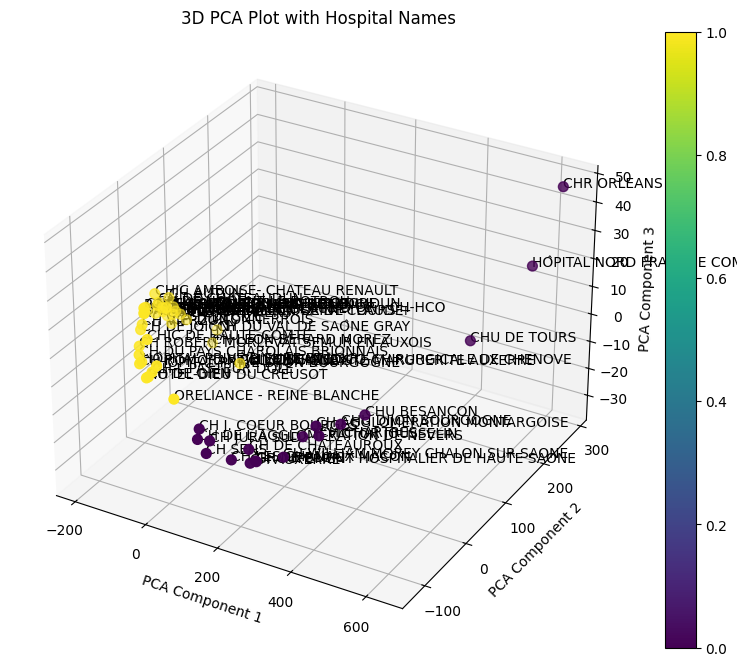

In [95]:
plot_pca_3D(dtw_matrix, n_clusters, etabs, save_dir=dir)

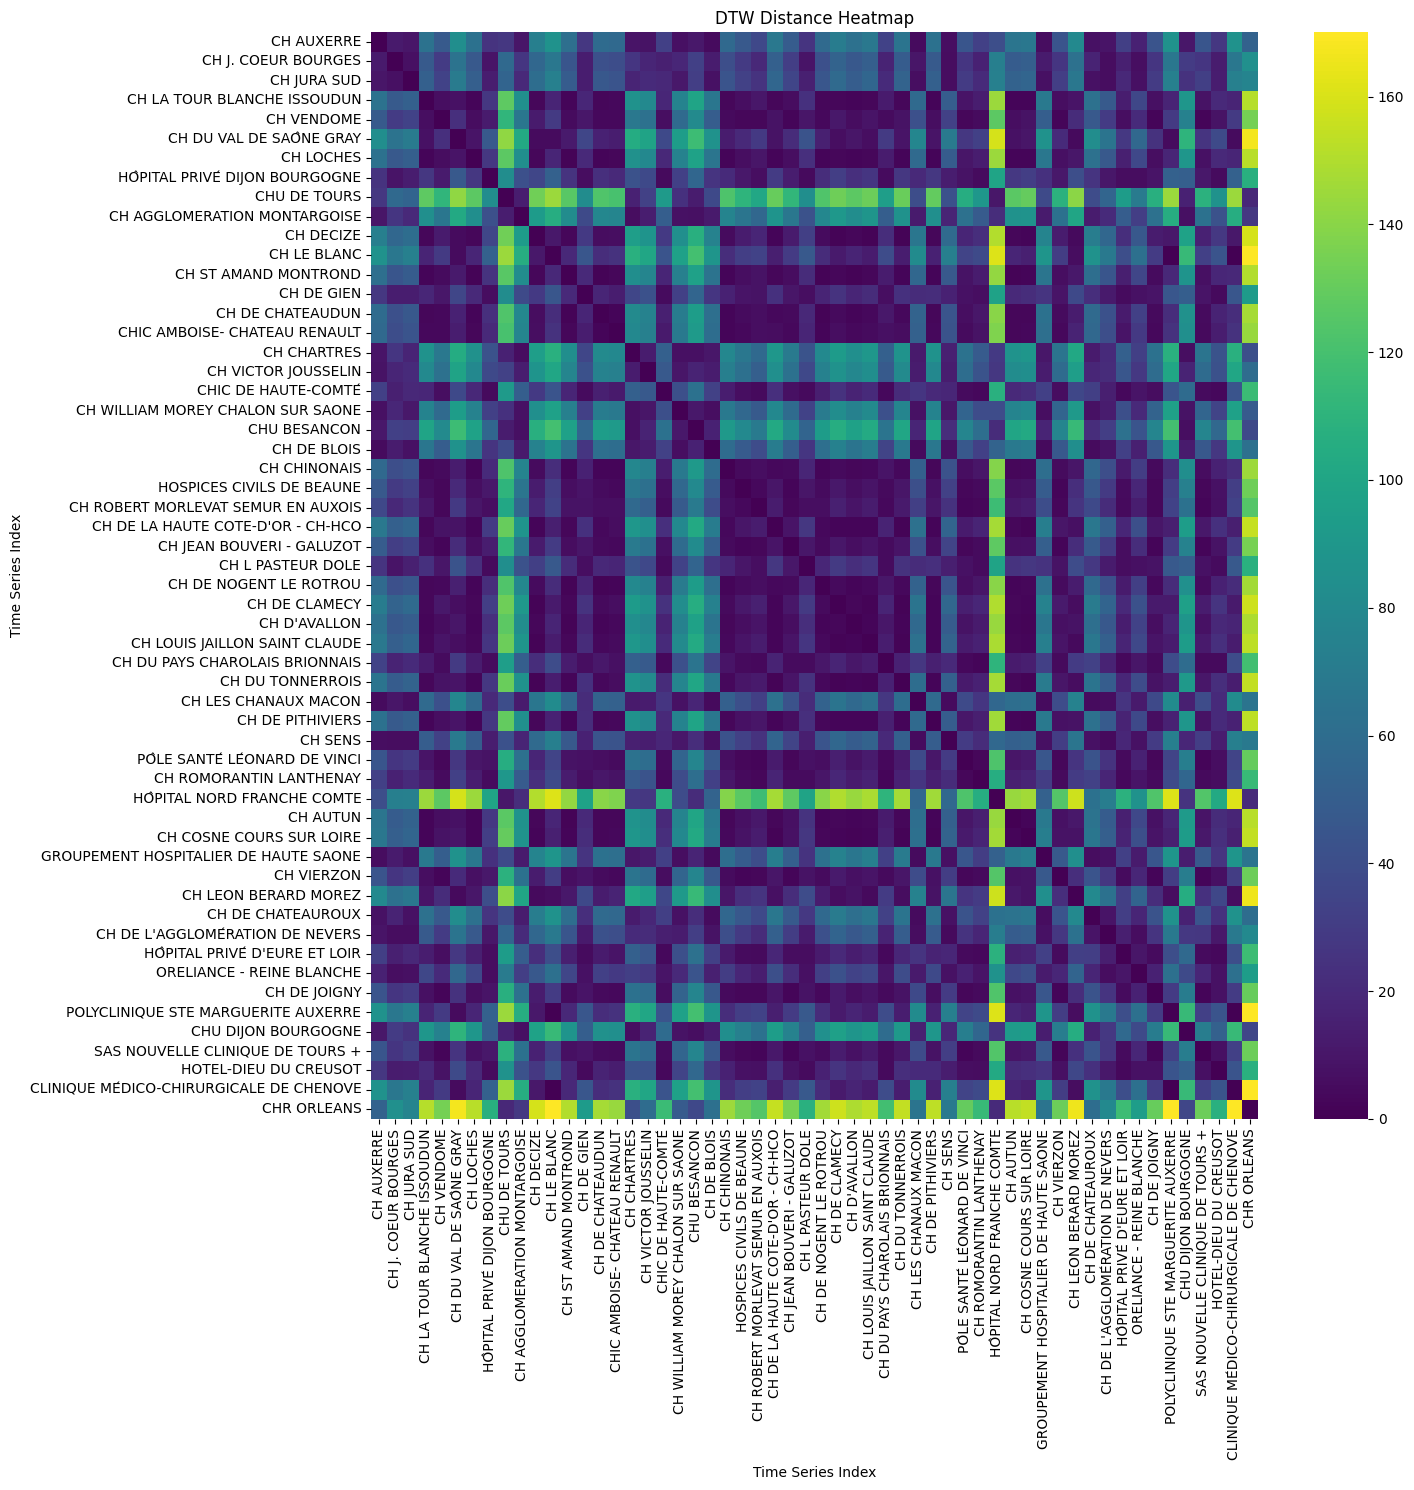

In [96]:
plot_heatmap(dtw_matrix, etabs, save_dir=dir)

### Plotting Total signals in clusters

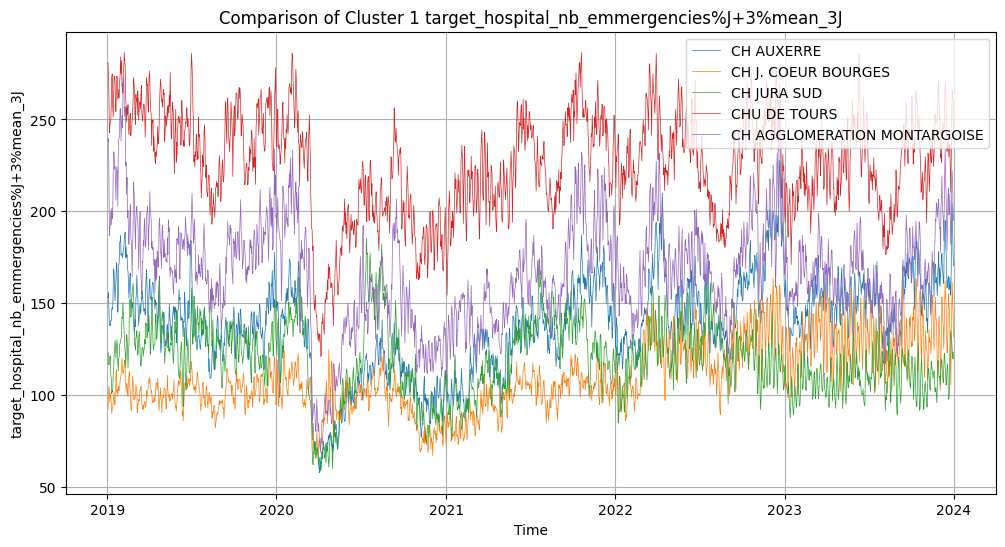

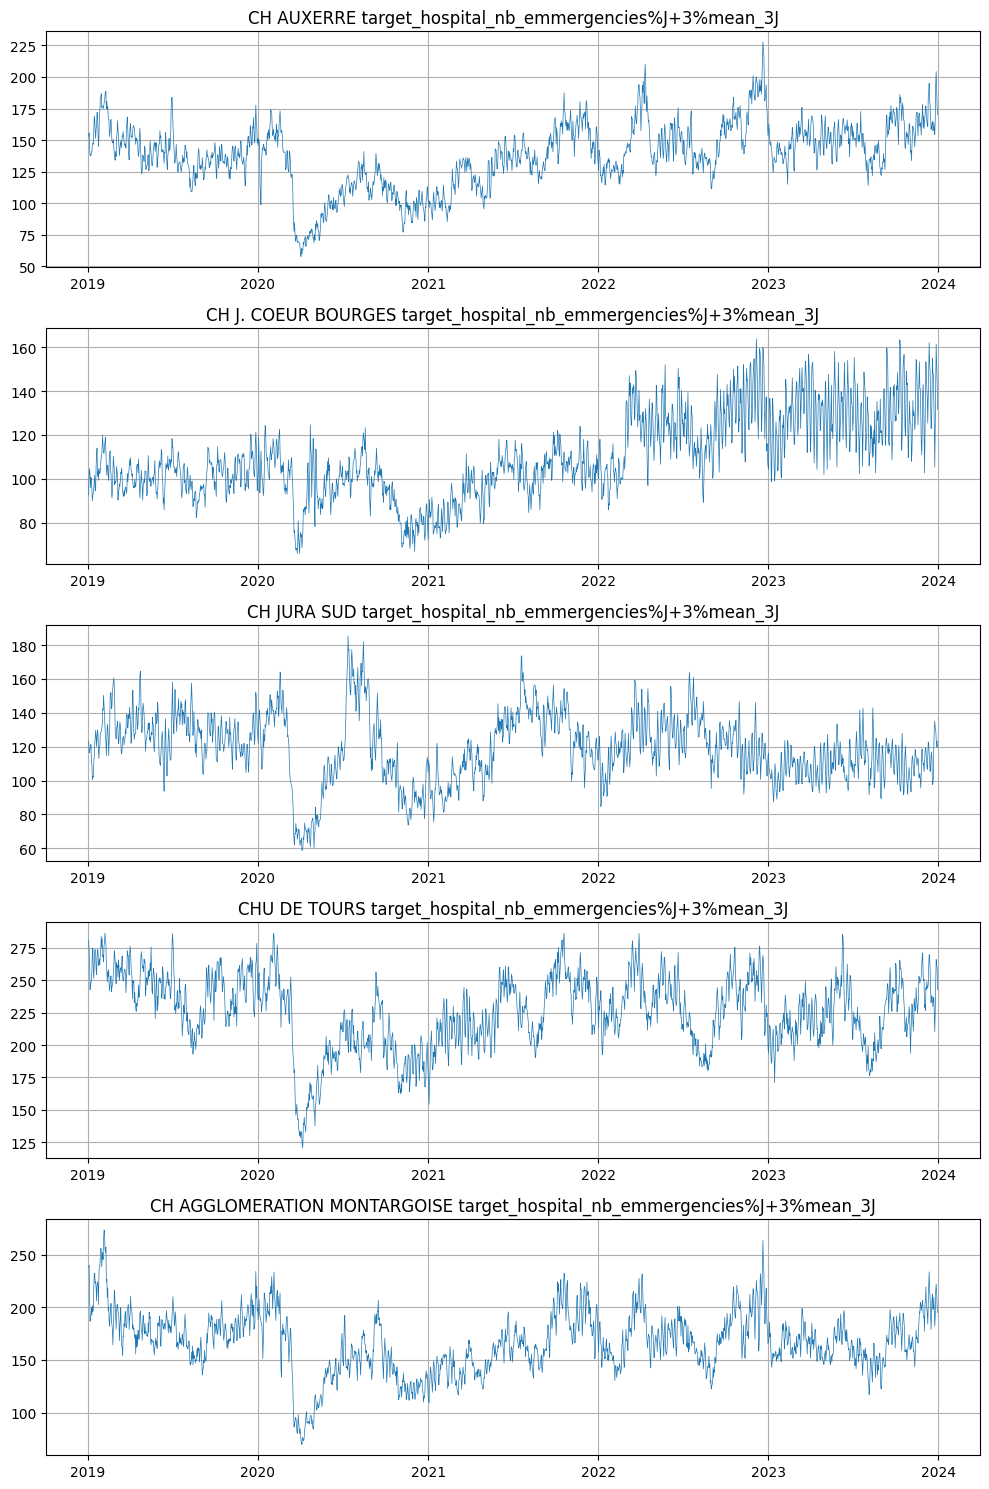

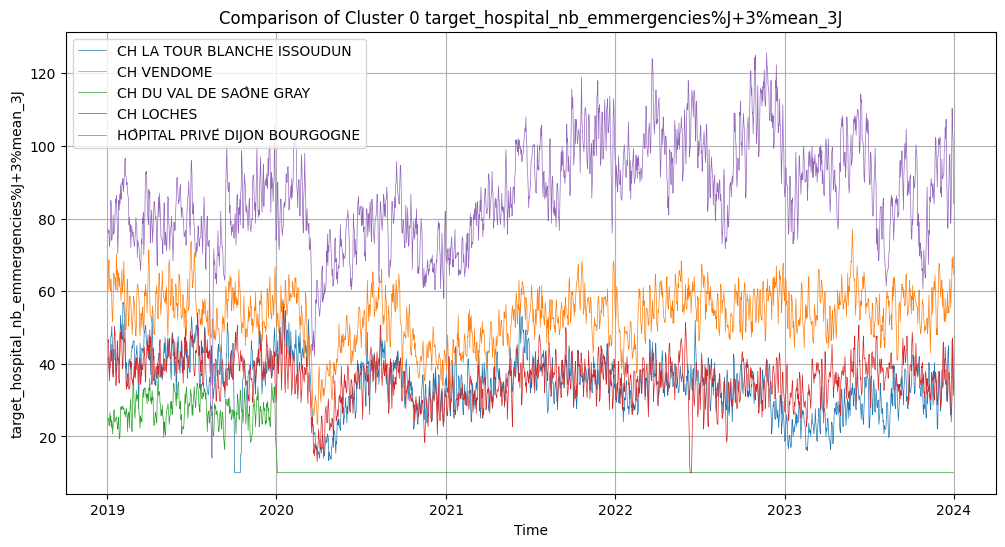

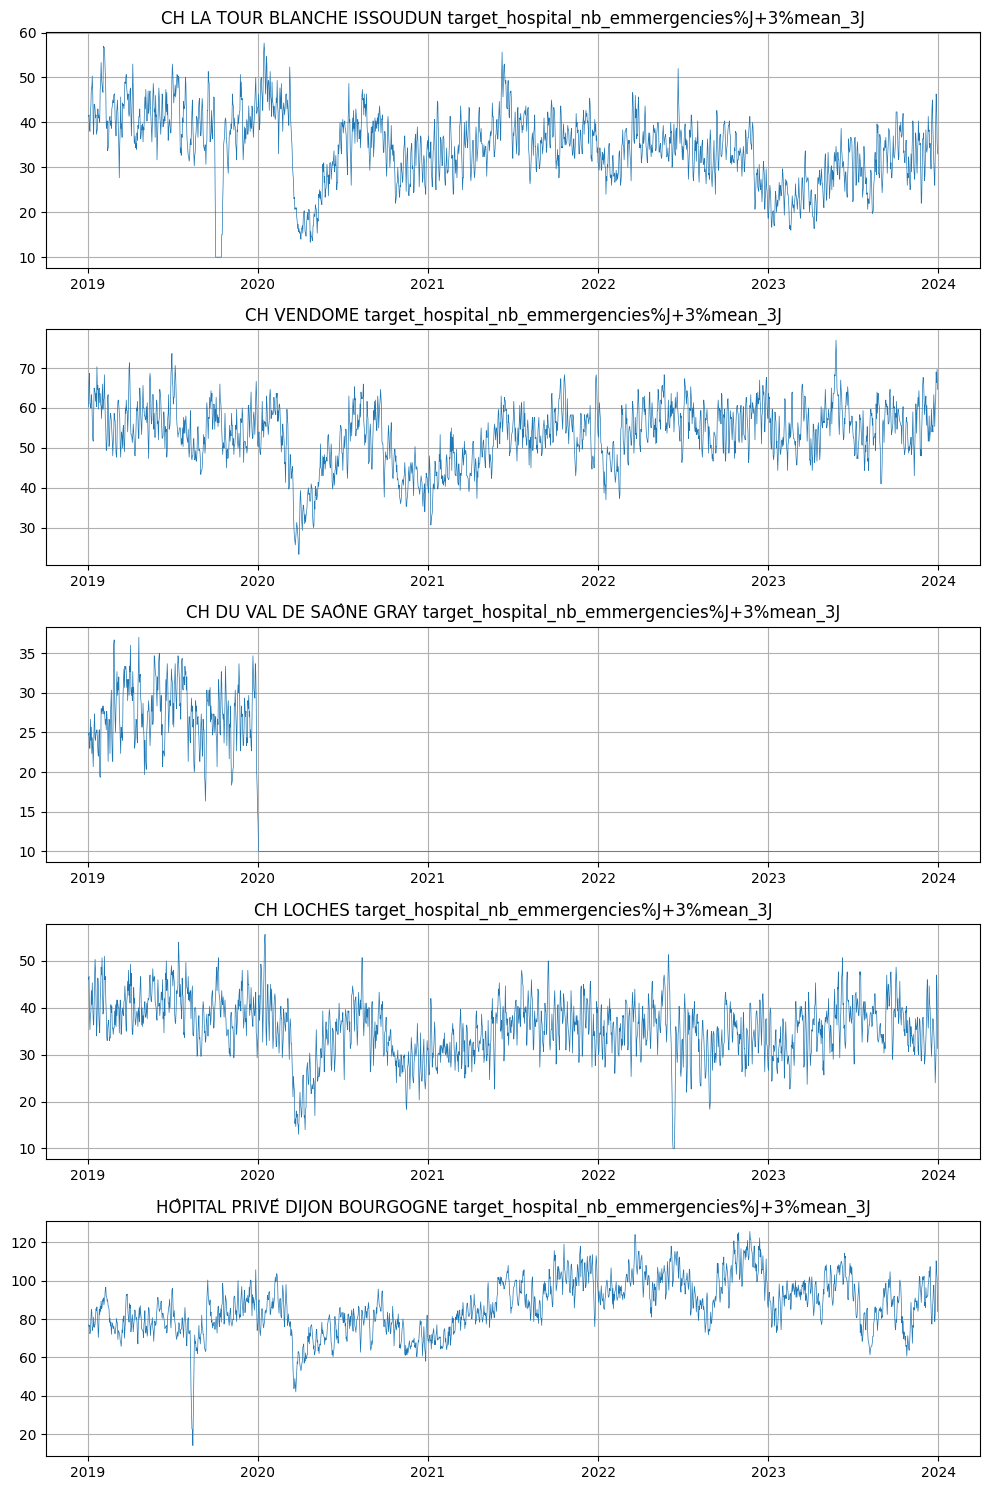

In [99]:
if ENDOGENOUS:
    cut = 5
    for cluster in clusters_etab:
            ts = []
            for etab in clusters_etab[cluster]:
                ts.append(datasets[etabs.index(etab)][target_column])
            plot_time_series(ts[:cut], date_range, clusters_etab[cluster][:cut], value=target_column, title='Cluster ' + str(cluster), cluster=str(cluster), save_dir=dir)
            subplots_time_series(ts[:cut], date_range, clusters_etab[cluster][:cut], value=target_column, cluster=str(cluster), save_dir=dir)

### Plotting Total average in clusters

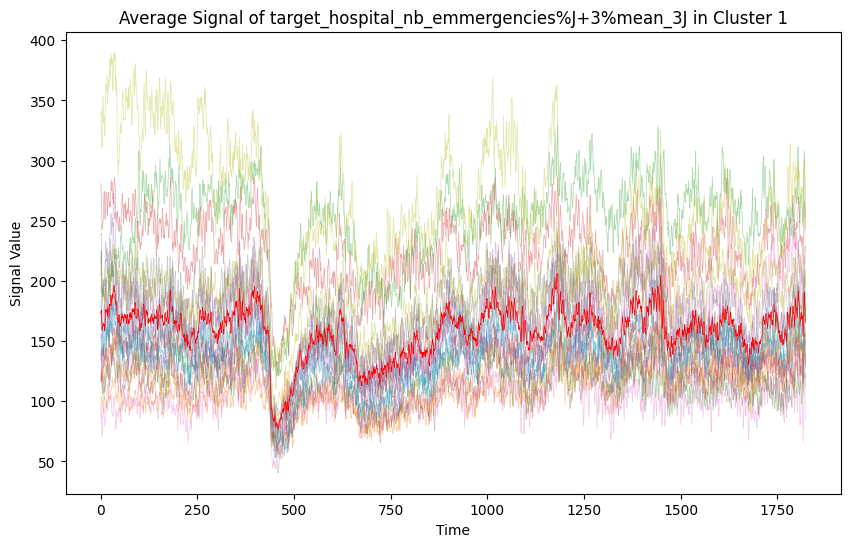

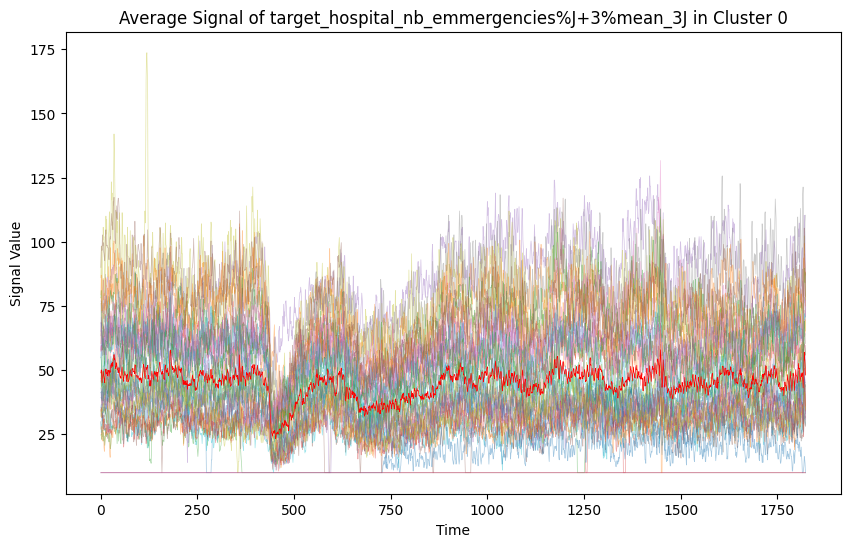

In [100]:
dico = {}
if ENDOGENOUS:
    for cluster in clusters_etab:
        df = pd.DataFrame()
        for etab in clusters_etab[cluster]:
            df[etab] = datasets[etabs.index(etab)][target_column]
        dico[cluster] = df


    for key in dico:
        average_signal = dico[key].mean(axis=1 )
        plt.figure(figsize=(10, 6))
        for etab in dico[key]:
            dico[key][etab].plot(label=etab, linewidth=0.5, alpha=0.4)
        average_signal.plot(label='Average Signal', color='r', linewidth=0.5)
        
        plt.xlabel('Time')
        plt.ylabel('Signal Value')
        title = f'Average Signal of {target_column} in Cluster ' + str(key)
        plt.title(title)
        # plt.legend()
        if dir != None: plt.savefig(dir + f"{title}.png", format="png", dpi=300)
        plt.show()


